In [14]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.science.utilities import financial_utils, time_series_utils

In [15]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [16]:
_SYMBOL = 'KO'
_DATE = '2020-05-06'

In [17]:
query = f"""
    select *
    from td.equities
    where symbol = '{_SYMBOL}'
        and market_datetime::date = '{_DATE}'
    limit 10
    """
stocks = utils.query_db(query=query)
stocks.head(3).T

,0
symbol,KO
open,45.4
high,45.63
low,44.72
close,44.75
volume,1.18929e+07
market_datetime_epoch,1588741200000.0
empty,False
market_datetime,2020-05-06 05:00:00
file_datetime,2020-05-28 00:03:41


In [18]:
query = f"""
    with dates as (
        select *
            , file_datetime at time zone 'utc' as _file_datetime
            , extract('hour' from file_datetime at time zone 'utc') _hour
            , extract('month' from file_datetime) _month
            , extract('year' from file_datetime) _year
        from td.options_detail
        where symbol = '{_SYMBOL}'
        ),
    days as (
        select *
            , extract('day' from case when _hour >= 16 then _file_datetime + interval '1 day' else _file_datetime end) as _day
        from dates
        where _hour not between 9 and 16
        ),
    base as (
        select *
            , dense_rank() over (partition by symbol, _year, _month, _day order by file_datetime desc) as dr
            , (_year || '-' || lpad(_month::varchar, '2', '0') || '-' || lpad(_day::varchar, '2', '0'))::date as market_datetime
        from days
        ),
    opts as (
        select
            symbol
            , put_call
            , bid
            , ask
            , (bid + ask)/2 as price
            , total_volume
            , open_interest
            , strike
            , days_to_expiration
            , market_datetime
        from base
        where dr = 1
        )
    select
        c.symbol
        , c.market_datetime
        , c.strike
        , c.days_to_expiration
        , c.bid as call_bid
        , c.ask as call_ask
        , c.price as call_price
        , p.bid as put_bid
        , p.ask as put_ask
        , p.price as put_price
        , c.price - p.price as forward
        , c.price + p.price as cumulative_premium
        , c.price + c.strike as call_breakeven
        , p.price + p.strike as put_breakeven
        , c.total_volume as call_total_volume
        , p.total_volume as put_total_volume
        , c.open_interest as call_open_interest
        , p.open_interest as put_open_interest
    from opts as c
    inner join opts as p
        on c.symbol = p.symbol
        and c.market_datetime = p.market_datetime
        and c.put_call <> p.put_call
        and c.strike = p.strike
        and c.days_to_expiration = p.days_to_expiration
    where c.put_call = 'CALL' and c.market_datetime = '{_DATE}'
    order by c.symbol, c.market_datetime, c.strike, c.days_to_expiration
    """
options = utils.query_db(query=query)
options.head(3).T

,0,1,2
symbol,KO,KO,KO
market_datetime,2020-05-06,2020-05-06,2020-05-06
strike,20,20,20
days_to_expiration,10,45,108
call_bid,25.3,25.3,25.3
call_ask,25.6,25.65,25.7
call_price,25.45,25.475,25.5
put_bid,0,0,0.06
put_ask,0.03,0.01,0.11
put_price,0.015,0.005,0.085


### Put call parity

In [19]:
options['moneyness'] = stocks['open'].values - options['strike']
options['discount'] = options['forward'] / options['moneyness']
options['discount_rate'] = options['discount'].apply(lambda x: np.log(x) if x > 0 else -1)

options['call_distance'] = options['call_breakeven'] - stocks['open'].values
options['put_distance'] = stocks['open'].values - options['put_breakeven']
options['percent_call_distance'] = options['call_distance']/stocks['open'].values

options.head()

,symbol,market_datetime,strike,days_to_expiration,call_bid,call_ask,call_price,put_bid,put_ask,put_price,...,call_total_volume,put_total_volume,call_open_interest,put_open_interest,moneyness,discount,discount_rate,call_distance,put_distance,percent_call_distance
0,KO,2020-05-06,20.0,10.0,25.30,25.60,25.450,0.00,0.03,0.015,...,0.0,0.0,0.0,23.0,25.4,1.001378,0.001377,0.050,25.385,0.001101
1,KO,2020-05-06,20.0,45.0,25.30,25.65,25.475,0.00,0.01,0.005,...,0.0,0.0,1.0,478.0,25.4,1.002756,0.002752,0.075,25.395,0.001652
2,KO,2020-05-06,20.0,108.0,25.30,25.70,25.500,0.06,0.11,0.085,...,0.0,0.0,0.0,5.0,25.4,1.000591,0.000590,0.100,25.315,0.002203
3,KO,2020-05-06,20.0,136.0,25.25,25.65,25.450,0.00,0.15,0.075,...,0.0,0.0,0.0,12.0,25.4,0.999016,-0.000985,0.050,25.325,0.001101
4,KO,2020-05-06,20.0,199.0,25.20,25.85,25.525,0.17,0.25,0.210,...,0.0,0.0,1.0,36.0,25.4,0.996654,-0.003352,0.125,25.190,0.002753


In [20]:
def plot(title, x, y, vline=None, ymin=None, ymax=None, hline=None, xmin=None, xmax=None, show=True):
    plt.title(title)
    plt.plot(x, y)
    if vline is not None:
        plt.vlines(
            vline,
            ymin=ymin,
            ymax=ymax,
            colors='r',
            linestyles='dotted'
        )
    if hline is not None:
        plt.hlines(
            hline,
            xmin=xmin,
            xmax=xmax,
            colors='r',
            linestyles='dotted'
        )
    if show:
        plt.show()

In [21]:
_N_EXPIRATION = 4
_expiration = np.sort(options['days_to_expiration'].unique())[_N_EXPIRATION]
_s = options[options['days_to_expiration'] == _expiration]

_N_STRIKE = 3
_strike = np.sort(options['strike'].unique())[_N_STRIKE]
_e = options[options['strike'] == _strike]

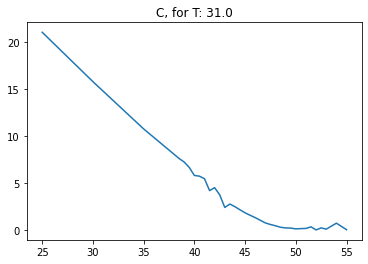

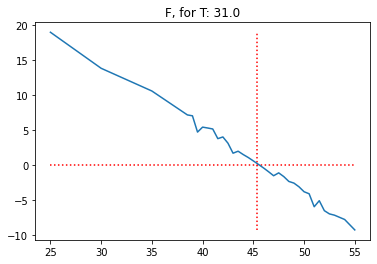

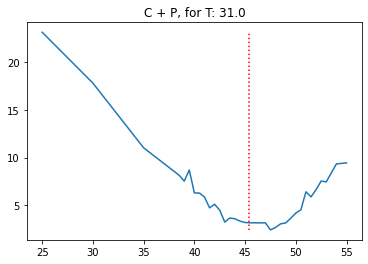

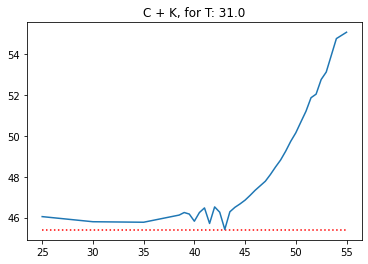

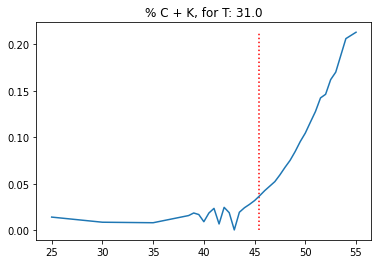

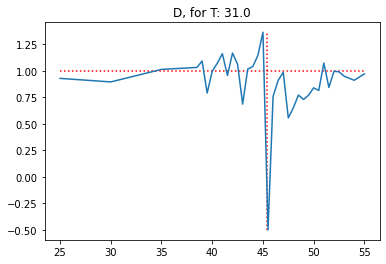

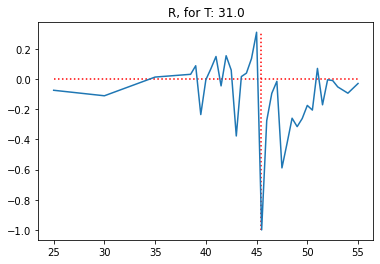

In [22]:
plot(
    title=f'C, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['call_price']
)

plot(
    title=f'F, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['forward'],
    vline=stocks['open'],
    ymin=_s['forward'].min(),
    ymax=_s['forward'].max(),
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
)

plot(
    title=f'C + P, for T: {_expiration}',
    x=_s['strike'],
    y=_s['cumulative_premium'],
    vline=stocks['open'],
    ymin=_s['cumulative_premium'].min(),
    ymax=_s['cumulative_premium'].max()
)

plot(
    title=f'C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['call_breakeven'],
    hline=stocks['open'],
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max()
)

plot(
    title=f'% C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['percent_call_distance'],
    vline=stocks['open'],
    ymin=_s['percent_call_distance'].min(),
    ymax=_s['percent_call_distance'].max()
)

plot(
    title=f'D, for T: {_expiration}',
    x=_s['strike'],
    y=_s['discount'],
    hline=1,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
    vline=stocks['open'],
    ymin=_s['discount'].min(),
    ymax=_s['discount'].max()
)

plot(
    title=f'R, for T: {_expiration}',
    x=_s['strike'],
    y=_s['discount_rate'],
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
    vline=stocks['open'],
    ymin=_s['discount_rate'].min(),
    ymax=_s['discount_rate'].max()
)

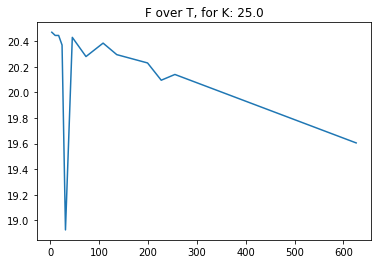

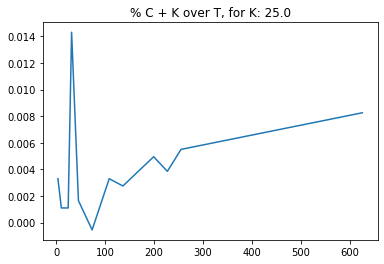

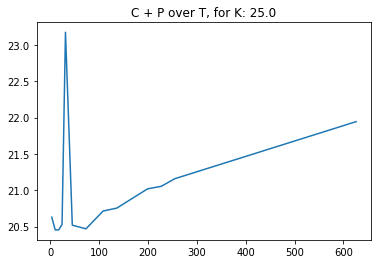

In [23]:
plot(
    title=f'F over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['forward']
)

plot(
    title=f'% C + K over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['percent_call_distance']
)

plot(
    title=f'C + P over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['cumulative_premium']
)

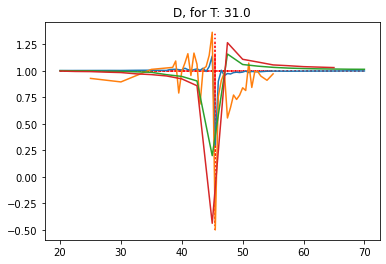

,strike,days_to_expiration,call_price,put_price,forward,discount
110,40.0,3.0,5.575,0.015,5.560,1.029630
111,40.0,10.0,5.500,0.065,5.435,1.006481
112,40.0,17.0,5.800,0.165,5.635,1.043519
113,40.0,24.0,5.725,0.235,5.490,1.016667
114,40.0,31.0,5.825,0.455,5.370,0.994444
115,40.0,38.0,6.050,0.365,5.685,1.052778
116,40.0,45.0,5.850,0.575,5.275,0.976852
117,40.0,73.0,6.125,0.935,5.190,0.961111
118,40.0,108.0,6.450,1.340,5.110,0.946296
119,40.0,136.0,6.575,1.615,4.960,0.918519


In [24]:
for n in [1, 4, 8, 10]:
    expiration = np.sort(options['days_to_expiration'].unique())[n]
    s = options[options['days_to_expiration'] == expiration].copy()

    plot(
        title=f'D, for T: {_expiration}',
        x=s['strike'],
        y=s['discount'],
        hline=1,
        xmin=s['strike'].min(),
        xmax=s['strike'].max(),
        vline=stocks['open'],
        ymin=s['discount'].min(),
        ymax=s['discount'].max(),
        show=False
    )

plt.show()

options.loc[options['strike']==40, ['strike', 'days_to_expiration', 'call_price', 'put_price', 'forward', 'discount']]

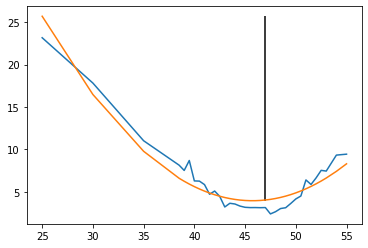

In [25]:
coefficients = np.polyfit(_s['strike'], _s['cumulative_premium'], deg=2)
smoothed_cumulative_premium = np.polyval(coefficients, _s['strike'])

plt.plot(
    _s['strike'],
    _s['cumulative_premium']
)

plt.plot(
    _s['strike'], 
    smoothed_cumulative_premium
)

plt.vlines(
    _s['strike'].values[20],
    ymin=smoothed_cumulative_premium.min(),
    ymax=smoothed_cumulative_premium.max()
)
plt.show()

In [27]:
s[['strike', 'days_to_expiration', 'call_price', 'put_price', 'forward', 'discount']]

,strike,days_to_expiration,call_price,put_price,forward,discount
4,20.0,199.0,25.525,0.210,25.315,0.996654
11,22.5,199.0,23.050,0.310,22.740,0.993013
26,25.0,199.0,20.625,0.395,20.230,0.991667
34,27.5,199.0,18.175,0.515,17.660,0.986592
49,30.0,199.0,15.800,0.665,15.135,0.982792
56,32.5,199.0,13.425,0.905,12.520,0.970543
72,35.0,199.0,11.250,1.230,10.020,0.963462
89,37.5,199.0,9.175,1.665,7.510,0.950633
120,40.0,199.0,7.225,2.240,4.985,0.923148
156,42.5,199.0,5.525,3.035,2.490,0.858621


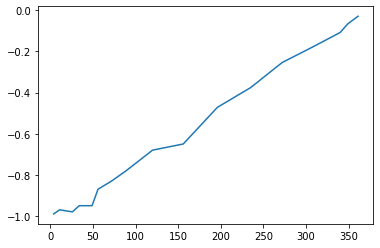

In [34]:
plt.plot(
    (s['call_price']-s['call_price'].shift(-1))/(s['strike']-s['strike'].shift(-1))
)

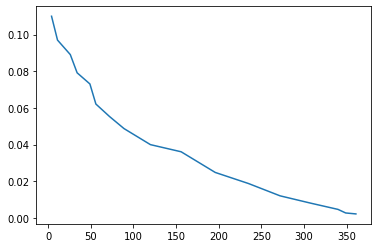

In [35]:
plt.plot(
    (s['call_price']-s['call_price'].shift(-1))/(s['strike'].shift(-1))
)

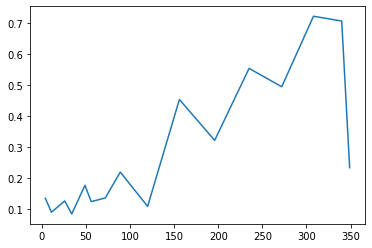

In [42]:
x = (s['call_price']-s['call_price'].shift(-1))/(s['strike'].shift(-1))

plt.plot((x - x.shift(-1))/x.shift(-1))